In [1]:
import os, sys
import pandas as pd
import numpy as np
import numpy.matlib
import scipy as sp

import geopandas as gpd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

Load map of australia using postcode data

In [2]:
aus_map = gpd.read_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/aus_map/aus_poas.shp')

In [3]:
aus_map.head()

,POA_NAME,code,state,geometry
0,6000,6000,None,"POLYGON ((115.86782 -31.95340, 115.86782 -31.9..."
1,6003,6003,None,"MULTIPOLYGON (((115.85039 -31.94570, 115.85065..."
2,6004,6004,None,"POLYGON ((115.86782 -31.95340, 115.86781 -31.9..."
3,6005,6005,None,"POLYGON ((115.84809 -31.93646, 115.84809 -31.9..."
4,6006,6006,None,"POLYGON ((115.84641 -31.92420, 115.84635 -31.9..."


Pull out VIC/NSW

In [4]:
aus_map['state'].unique()

array([None, 'VIC'], dtype=object)

The 'state' column only has 'VIC'... that's weird. Let's use the postcodes to stitch together state maps

Wikipedia to the rescue! https://en.wikipedia.org/wiki/Postcodes_in_Australia

Victoria spans postcodes 3000 to 3999 inclusive

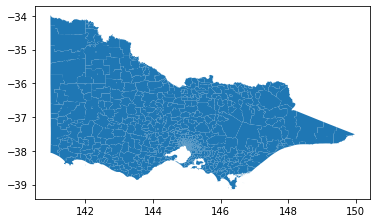

In [5]:
vic_map = aus_map.loc[np.logical_and(aus_map['code'] >= 3000, aus_map['code'] <= 3999),:]
ax = vic_map.plot()

NSW spans postcodes 2000 to 2999, if you include the ACT

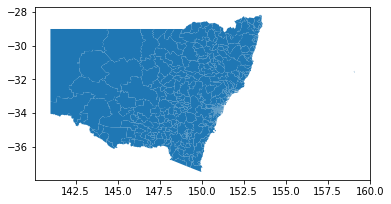

In [6]:
nsw_map = aus_map.loc[np.logical_and(aus_map['code'] >= 2000, aus_map['code'] <= 2999),:]
ax = nsw_map.plot()

There is some weird spot way out east that shouldn't be there - around 160 longitude

In [7]:
xmin, ymin, xmax, ymax = nsw_map.total_bounds
print(xmin, ymin, xmax, ymax)

140.99947452772733 -37.505059998220304 159.10921900835058 -28.15701991393786


Cut at 155 longitude

In [8]:
nsw_map = nsw_map.cx[xmin:155, ymin:ymax]

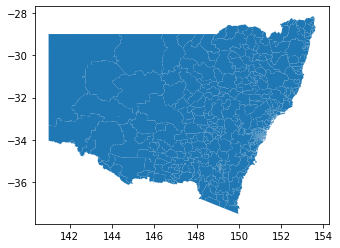

In [9]:
ax = nsw_map.plot()

Better!

Merge

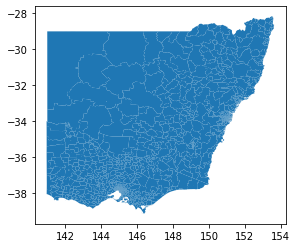

In [10]:
my_map = pd.concat((nsw_map, vic_map))
ax = my_map.plot()

In [11]:
my_map.reset_index(drop = True, inplace = True)
my_map['state'] = 'None'
my_map.head()

,POA_NAME,code,state,geometry
0,2648,2648,None,"POLYGON ((141.15285 -34.07935, 141.15286 -34.0..."
1,2717,2717,None,"POLYGON ((142.02848 -34.12087, 142.02849 -34.1..."
2,2735,2735,None,"POLYGON ((143.59179 -35.07012, 143.59177 -35.0..."
3,2736,2736,None,"POLYGON ((143.33290 -35.02792, 143.33290 -35.0..."
4,2737,2737,None,"POLYGON ((142.69939 -34.60174, 142.69941 -34.6..."


Load in fire data

In [12]:
# df = gpd.read_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/DL_FIRE_V1_101558/fire_nrt_V1_101558.shp')
# df = gpd.read_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/DL_FIRE_M6_101557/fire_nrt_M6_101557.shp')
df = gpd.read_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/DL_FIRE_M6_101557/fire_archive_M6_101557.shp')
df.shape

(5052524, 16)

In [13]:
df.head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,-17.0427,143.9288,320.7,4.1,1.9,2000-11-01,0016,Terra,MODIS,30,6.2,300.6,60.3,D,0,POINT (143.92880 -17.04270)
1,-17.0441,143.8489,326.5,4.1,1.9,2000-11-01,0016,Terra,MODIS,60,6.2,298.8,110.5,D,0,POINT (143.84890 -17.04410)
2,-17.0518,143.8872,322.1,4.1,1.9,2000-11-01,0016,Terra,MODIS,31,6.2,298.9,72.3,D,0,POINT (143.88720 -17.05180)
3,-16.4447,143.5152,321.0,4.5,2.0,2000-11-01,0016,Terra,MODIS,62,6.2,300.5,71.6,D,0,POINT (143.51520 -16.44470)
4,-16.4439,143.5076,319.9,4.5,2.0,2000-11-01,0016,Terra,MODIS,59,6.2,300.6,62.8,D,0,POINT (143.50760 -16.44390)


## Retain only fire data that intersects with my map

Scrub out postcode boundaries and store in separate variable. We'll use this below to retain fire data inside our map.

In [14]:
my_map_nopost = my_map.dissolve(by='state')
my_map_nopost.reset_index(drop = True, inplace = True)
my_map_nopost.drop(['POA_NAME','code'], axis = 1, inplace = True)

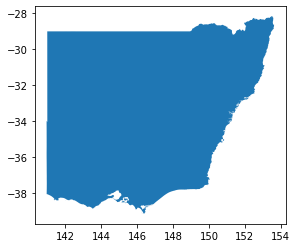

In [15]:
ax = my_map_nopost.plot()

Drop rows outside the general bounds of my map (long,lat)

In [16]:
xmin, ymin, xmax, ymax = my_map_nopost.total_bounds
print(xmin, ymin, xmax, ymax)

140.96168198373664 -39.15918952707494 153.63872700774527 -28.15701991393786


In [17]:
df = df.cx[xmin:xmax, ymin:ymax]
df.reset_index(drop = True, inplace = True)
df.shape

(482736, 16)

In [18]:
df.head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,-30.5863,151.2951,325.7,1.0,1.0,2000-11-01,0019,Terra,MODIS,80,6.2,293.9,18.1,D,0,POINT (151.29510 -30.58630)
1,-30.5773,151.2968,313.0,1.0,1.0,2000-11-01,0019,Terra,MODIS,52,6.2,294.5,6.1,D,0,POINT (151.29680 -30.57730)
2,-30.7754,151.1438,342.8,1.0,1.0,2000-11-01,0019,Terra,MODIS,80,6.2,294.2,42.9,D,0,POINT (151.14380 -30.77540)
3,-30.3560,151.7422,316.8,1.0,1.0,2000-11-01,0019,Terra,MODIS,69,6.2,295.7,9.0,D,0,POINT (151.74220 -30.35600)
4,-31.5540,147.0632,318.9,1.3,1.1,2000-11-01,0020,Terra,MODIS,73,6.2,296.2,12.6,D,0,POINT (147.06320 -31.55400)


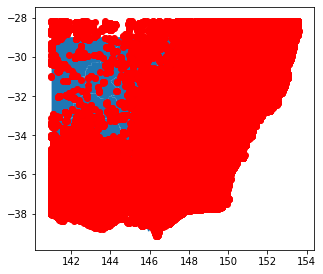

In [19]:
fig, ax = plt.subplots(figsize = (5,5))
my_map.plot(ax = ax)
df.plot(ax = ax, color = 'r')

In [20]:
from IPython.display import clear_output

In [21]:
def update_progress(progress, my_str = ''):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = my_str + " Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [22]:
mask = my_map_nopost.geometry.unary_union

In [23]:
my_bool = np.zeros((df.shape[0],), dtype=bool)

In [24]:
for data in df.iterrows():
    update_progress(data[0]/df.shape[0])
    my_bool[data[0]] = data[1].geometry.within(mask)
update_progress(1)

 Progress: [####################] 100.0%


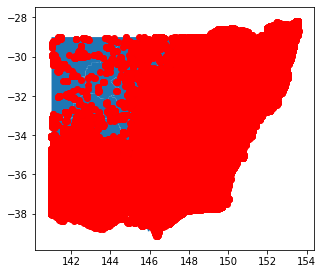

In [25]:
fig, ax = plt.subplots(figsize = (5,5))
my_map.plot(ax = ax)
df.loc[my_bool,:].plot(ax = ax, color = 'r')

In [26]:
df.loc[my_bool,:].shape

(450028, 16)

## Save out

In [27]:
my_map.to_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/my_map.shp')
df.loc[my_bool,:].to_file('/Users/lindenmp/Dropbox/PersonalProjects/NASA_aus_firedata/data/df.shp')